In [ ]:
pip install -q git+https://github.com/eaedk/testing-zindi-package.git

In [ ]:
from zindi.user import Zindian

In [ ]:
# access zindi account
zindi_username = "ddnazzah"
zindi_account = Zindian(username = zindi_username)

Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome ddnazzah 👋🏾👋🏾



In [4]:
zindi_account.select_a_challenge()                               # Select a Zindi challenge based on account, [check challenge 4]
zindi_account.which_challenge                                    # Get information about the selected challenge


__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
----------------------------------------------------------------------------------------------------------------------------------
|  0  |Public Compet |Automatic Speech R|     $3 000 USD     | mozilla-luganda-automatic-speech-recognition...
----------------------------------------------------------------------------------------------------------------------------------
|  1  |Public Compet |    Prediction    |     $3 000 USD     | zindi-user-behaviour-birthday-challenge...
----------------------------------------------------------------------------------------------------------------------------------
|  2  |Public Compet |  Classification  

In [5]:
zindi_account.download_dataset(destination="dataset") # Download the dataset for the challenge chosen.

Exception: ignored

In [ ]:
!unzip 'dataset/Train_Images.zip' -d ''
!unzip 'dataset/Test_Images.zip' -d ''

In [6]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [7]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [8]:
# train and test directories, load files into variables
train_dir = 'dataset/Train.csv'
test_dir = 'dataset/Test.csv'

train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

# add new features xmax and ymax and classes
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [9]:
df = train_df.copy()

df.drop('width', inplace=True, axis=1)
df.drop('height', inplace=True, axis=1)
df.head()


,Image_ID,class,xmin,ymin,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5


In [10]:
df = df.to_numpy()
df = df.tolist()

In [11]:
for row in df:
  imageId, label, startX, startY, endX, endY = row
  imagePath = 'Train_Images/'+imageId + '.jpg'

  #load image
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]

  #scale bounding boxes
  startX  = float(startX) / w
  startY  = float(startY) / h
  endX  = float(endX) / w
  endY  = float(endY) / h

  #load and preproess image
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)

  #update
  data.append(image)
  labels.append(label)
  bboxes.append((startX, startY, endX, endY))
  imagePaths.append(imagePath)

In [12]:
#convert data to nupy array
#scale image data to 0-1
data = np.array(data, dtype='float32')/255.0
labels = np.array(labels)
bboxes = np.array(bboxes,dtype='float32')
imagePaths = np.array(imagePaths)

#perform onehot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [17]:
image = np.expand_dims(data[0],axis=1)
image

array([[[[0.36862746, 0.5411765 , 0.19215687],
         [0.37254903, 0.5568628 , 0.19607843],
         [0.36862746, 0.5647059 , 0.19215687],
         ...,
         [0.6156863 , 0.7137255 , 0.49019608],
         [0.62352943, 0.7254902 , 0.4862745 ],
         [0.6       , 0.7137255 , 0.45490196]]],


       [[[0.37254903, 0.54509807, 0.19607843],
         [0.3764706 , 0.56078434, 0.2       ],
         [0.36078432, 0.5568628 , 0.18431373],
         ...,
         [0.6901961 , 0.77254903, 0.5411765 ],
         [0.6784314 , 0.7490196 , 0.52156866],
         [0.6431373 , 0.72156864, 0.49019608]]],


       [[[0.38039216, 0.5568628 , 0.2       ],
         [0.3764706 , 0.56078434, 0.2       ],
         [0.36078432, 0.5529412 , 0.19215687],
         ...,
         [0.654902  , 0.7254902 , 0.49019608],
         [0.6313726 , 0.6862745 , 0.45490196],
         [0.69411767, 0.73333335, 0.5294118 ]]],


       ...,


       [[[0.7607843 , 0.8627451 , 0.58431375],
         [0.7607843 , 0.8666667 , 0.596

In [18]:
del image

In [19]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.2, random_state=34)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [25]:
# load the ResNet50V2 network, ensuring the head FC layers are left off
rn50v2 = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all ResNet50V2 layers so they will *not* be updated during the
# training process
rn50v2.trainable = False

# flatten the max-pooling output of VGG
flatten = rn50v2.output
flatten = Flatten()(flatten)

In [20]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [26]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=rn50v2.input,
	outputs=(bboxHead, softmaxHead))

In [27]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"],
    loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [28]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [29]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=32,
	epochs=20,
	verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save('model2_rn50v2base', save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open('model2_binarizer', "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/20
98/98 [==============================] - 63s 301ms/step - loss: 1.1761 - bounding_box_loss: 0.0342 - class_label_loss: 1.1419 - bounding_box_accuracy: 0.6364 - class_label_accuracy: 0.7609 - val_loss: 0.3788 - val_bounding_box_loss: 0.0290 - val_class_label_loss: 0.3498 - val_bounding_box_accuracy: 0.6829 - val_class_label_accuracy: 0.9066
Epoch 2/20
98/98 [==============================] - 26s 267ms/step - loss: 0.3813 - bounding_box_loss: 0.0238 - class_label_loss: 0.3574 - bounding_box_accuracy: 0.7119 - class_label_accuracy: 0.9052 - val_loss: 0.2083 - val_bounding_box_loss: 0.0274 - val_class_label_loss: 0.1809 - val_bounding_box_accuracy: 0.6829 - val_class_label_accuracy: 0.9437
Epoch 3/20
98/98 [==============================] - 26s 268ms/step - loss: 0.2007 - bounding_box_loss: 0.0205 - class_label_loss: 0.1802 - bounding_box_accuracy: 0.7542 - class_label_accuracy: 0.9395 - val_loss: 0.2314 - val_bounding_box_loss: 0.0282 - val_class_label_

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


[INFO] saving label binarizer...


The tain model show the following results:

loss: 0.0482
- bounding_box_loss: 0.0147
- class_label_loss: 0.0335
- bounding_box_accuracy: 0.8182
- class_label_accuracy: 0.9907
- val_loss: 0.4175
- val_bounding_box_loss: 0.0346
- val_class_label_loss: 0.3829
- val_bounding_box_accuracy: 0.7621
- val_class_label_accuracy: 0.9540

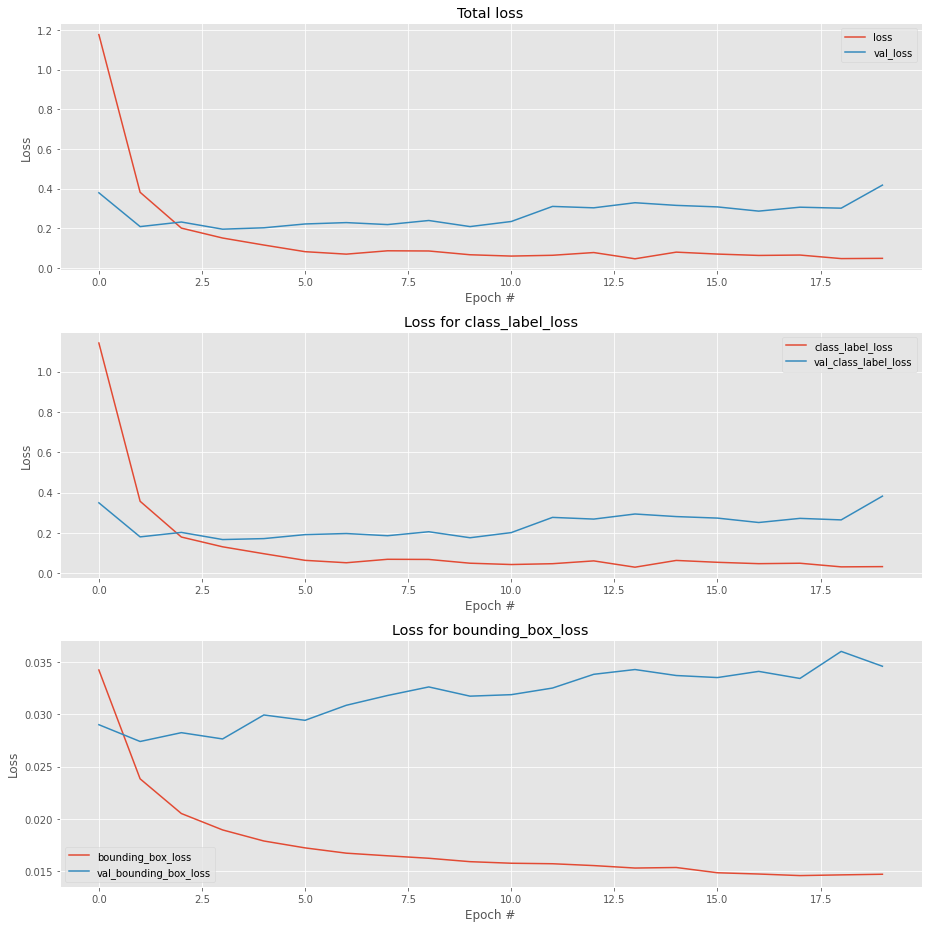

In [30]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
P = np.arange(0, 20)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(P, H.history[l], label=l)
	ax[i].plot(P, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

# display the plot
plt.tight_layout()
plt.show()

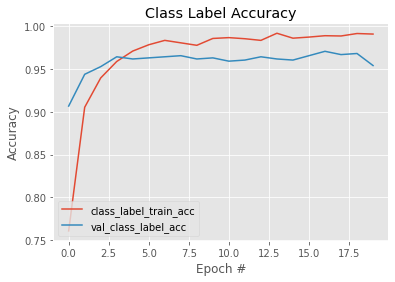

In [31]:
plt.style.use("ggplot")
plt.figure()
plt.plot(P, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(P, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# display the plot
plt.show()

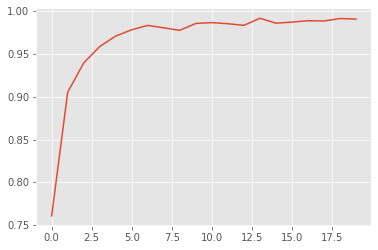

In [32]:
plt.plot(P, H.history["class_label_accuracy"],
	label="class_label_train_acc")

In [39]:
test_images_dir = 'Test_Images/'
test_df.head()
testImageIds = test_df['Image_ID'].to_numpy().tolist()
testImageIds
ids = []
label = []
xmin = []
confidence = []
ymin =[]
xmax= []
ymax=[]
count = 0
for tid in testImageIds:
  imagePath = test_images_dir+tid+'.jpg'
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)
  image = np.array(image, dtype='float32')/255.0
  image = np.expand_dims(image,axis=0)
  prediction = model.predict(image)
  startX,startY,endX,endY = prediction[0][0]
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]
  xmin.append(startX*w)
  ymin.append(startY*h)
  xmax.append(endX*w)
  ymax.append(endY*h)
  ids.append(tid)
  ce = np.amax(prediction[1][0])
  confidence.append(ce)
  idx = np.argmax(prediction[1][0])
  classes = ["fruit_brownspot","fruit_healthy","fruit_woodiness"]
  label.append(classes[idx])
  count += 1
#data transform

In [34]:
solution = pd.DataFrame({'Image_ID':ids})
solution['class'] = label
solution['confidence'] = confidence
solution['ymin'] = ymin
solution['xmin'] = xmin
solution['ymax'] = ymax
solution['xmax'] = xmax


In [35]:
submission = solution.copy()

In [36]:
submission.rename({0:'Image_ID'},axis='index')
submission.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_IUJJG62B,fruit_healthy,1.000000,279.840240,289.366791,426.820618,460.809418
1,ID_ZPNDRD4T,fruit_healthy,0.999998,263.239075,125.332031,404.609070,268.275757
2,ID_AHFYB64P,fruit_woodiness,0.999990,227.531403,217.595474,434.598969,378.175995
3,ID_L8JZLNTF,fruit_healthy,1.000000,182.103851,118.848465,410.043030,349.787415
4,ID_IFMUXGPL,fruit_woodiness,1.000000,157.412552,248.510040,343.166901,394.465088


In [37]:
submission.to_csv('submission.csv', index=False)
